#Notebook para el tutorial de python

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import os
#import cv2
import csv
import math
import pandas as pd

from nilearn import plotting
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps
from nilearn.plotting import show

import nibabel as nib
from nibabel.testing import data_path

import nilearn.masking

In [2]:
np.set_printoptions(precision=2, suppress=True)
data_path = 'data-tutorial'

# Cogemos los nombres de los diferentes archivos de nuestra carpeta data-tutorial que vamos a necesitar
PET_filename = 'sub-B10709603_ses-m00_AV1451.avg.nii'

T1_filename = 'sub-B10709603_ses-m00_T1.nii'

Mask_filename = 'sub-B10709603_ses-m00_T1_mask.nii'

Atlas_filename = 'sub-B10709603_ses-m00_desikanAtlas.nii'




##Trabajo con PET




Cargamos la imagen y vemos un poco el contenido del header, que contiene los metadatos del archivo

In [3]:
pet_img = nib.load(os.path.join(data_path, PET_filename))
print(pet_img.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 128 128  47   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.    2.73  2.73  3.27  0.    1.    1.    1.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'FreeSurfer Jul 23 2020'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 173.63281
qoffset_y       : -173.63281
qoffset_z       :




En lugar de printar el header entero, también podemos seleccionar uno de los campos, en este caso vamos a quedarnos con el contenido relacionado con la resolución de la imagen y con el tamaño de los voxels

In [4]:
print('resolución de la imagen: ' + str(pet_img.get_fdata().shape))
print('tamaño del voxel: ' + str(pet_img.header.get_zooms()))


resolución de la imagen: (128, 128, 47)
tamaño del voxel: (2.734375, 2.734375, 3.2700043)


A continuación mostramos un histograma con las intensidades que presenta el  PET

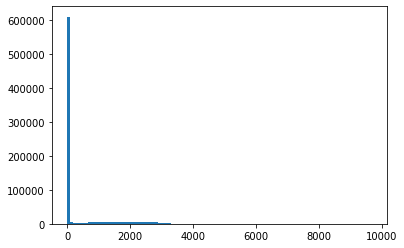

In [5]:
pet_img_data = pet_img.get_fdata()
'''
#####
La opcion de hacer un flatten es bien. El problema? No controlas la forma de reshaping, y puede dar problemas.
Por ejemplo, imaginate que tienes una matriz 4D (x,y,z,t) y quieres pasarla a una 2D con (x*y*z,t).
En muchos casos, nosotros usamos la funcion reshape. 
Give it a try.

Los histogramas es justo lo que te pediamos.
Que sucede? La imagen entera es un cubo (kidna). Mientras que los valores que tienen intensidad, solo son una pequeña parte
Recomiendo que, ademas de lo que has hecho, hagas otro histograma con un filtrado previo (<300 = 0, por ejemplo)
Asi se puede visualizar mejor la varianza de los datos del PET perse, negligiendo los zeros.
Tambien puedes hacer una segunda iteracion. Si ves que de 5000-10000 no hay CASI nada, puedes restringir los bins
del histograma para que queden cerrados entre 1000-5000)
#####
'''
#flatten_data_pet = np.ndarray.flatten(pet_img_data)
flatten_data_pet = pet_img_data.reshape(-1)     # Trabajaremos con esta opción para empezar a usar la libreria de numpy
plt.hist(flatten_data_pet, bins=100)
plt.show()


Como podemos apreciar en el histograma, existe una gran desviación en el valor de las intensidades de los voxels, en concreto, hay una gran cantidad de voxels que tienen valores cercanos a 0, de modo que vamos a volver a realizar el plot pero marcando un rango concreto para excluir valores que no nos interesan.

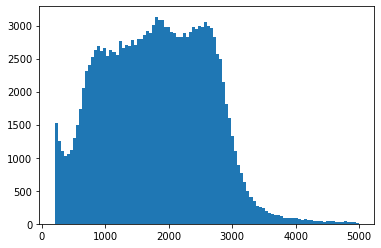

In [6]:
plt.hist(flatten_data_pet, range=(200,5000), bins=100)
plt.show()




Por último, mostraremos unas slices del PET que hemos cargado.

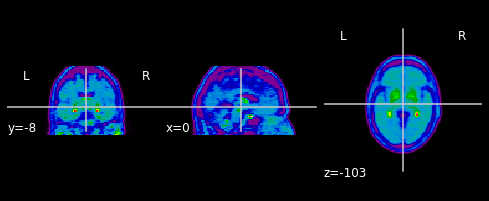

In [7]:
plotting.plot_epi(pet_img)
plotting.show()




##Trabajo con T1



En primer lugar, debemos cargar el archivo tal y como hemos hecho con el PET.

In [8]:
t1_img = nib.load(os.path.join(data_path, T1_filename))
t1_header = t1_img.header   # También podemos acceder a los datos del header
t1_data = t1_img.get_fdata()
t1_data.shape

(196, 256, 256)

In [9]:
print('-----Metadatos PET-----')
print('resolución de la imagen: ' + str(pet_img.get_fdata().shape))
print('tamaño del voxel: ' + str(pet_img.header.get_zooms()))
print()

print('-----Metadatos T1-----')
print('resolución de la imagen: ' + str(t1_img.get_fdata().shape))
print('tamaño del voxel: ' + str(t1_img.header.get_zooms()))

-----Metadatos PET-----
resolución de la imagen: (128, 128, 47)
tamaño del voxel: (2.734375, 2.734375, 3.2700043)

-----Metadatos T1-----
resolución de la imagen: (196, 256, 256)
tamaño del voxel: (1.2, 1.0547, 1.0547)


Como podemos observar, el T1 tiene más resolución que el PET, y por lo tanto, para un mismo volumen, usa voxels más pequeños.

#####
Lo que comentas es cierto, pero con un PERO.
Hay dos tipos de resolución en este caso. El del tamaño de voxel, y el del volumen perse.

Podemos ver que el tamaño de voxel es menor en T1 vs PET. La conclusion que podemos sacar (a diferencia de lo que has escrito) es que "un voxel en la imagen T1 nos da informacion de un espacio mas pequeño que en el PET, por tanto, la resolución espacial del T1 es mayor

Tambien podemos ver que el numero de slices es mayor en el de t1 vs PET. Hay una relación directa entre el tamaño de voxel y el numero de slices. Si te fijas en la tercera direccion Z, para PET hay un tamaño de 3.3 mientrs que para el T1 de 1. A si mismo, puedes ver como el numero de slices en la direccion Z es menor en el PET, que en el T1.

Al final, el cerebro que escaneas no cambia. Lo que cambia es como lo sampleas. Si lo sampleas a un tamaño de voxel mayor, tendras menos slices, y viceversa
#####


A continuación mostramos un histograma con las intensidades que presenta el T1

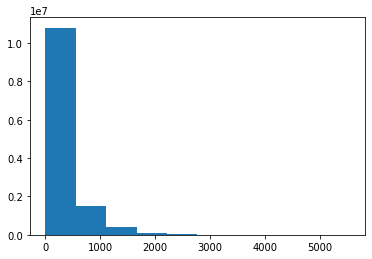

In [10]:
t1_img_data = t1_img.get_fdata()
'''
#####
Same comment que con el PET. Prueva a usar reshape en vez de flatten, y haz un par mas de histogramas quitando los zeros
y valores bajos
#####
'''
flatten_data_t1 = t1_img_data.reshape(-1)
plt.hist(flatten_data_t1)
plt.show()

Podemos afirmar que en este histograma aparece una distribución de intensidades similar al histograma original de PET, de modo que aplicaremos el mismo método para quedarnos con los valores que nos interesan.

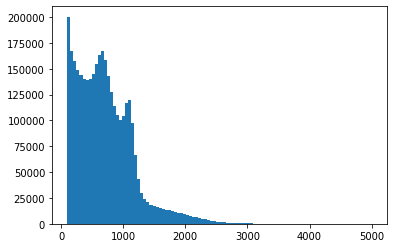

In [11]:
plt.hist(flatten_data_t1, range=(100,5000), bins=100)
plt.show()




Realizamos el plot del T1, en este caso, usaremos la función de plot_anat(...), que usa una escala de grises y es más adecuada para este tipo de imágenes

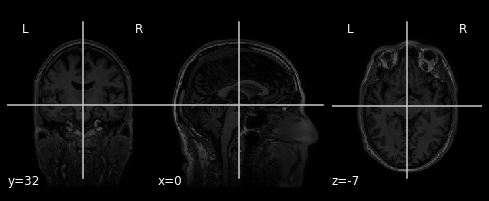

In [12]:
plotting.plot_anat(t1_img)
'''
#####
Solo a modo de ejemplo y para jugar, prueva a cambiar la escala de colores. Aqui tienes una que va de azules oscuros
a rojos intensos (default). 

Para las imagenes estructurales (como la T1), se suele usar una visualización en escala de grises.
Puedes provar tambien la funcion plot_anat
#####
'''
plotting.show()

Como ejemplo, podemos ver que existe una gran cantidad de mapas de color en la libreria matplotlib que podemos usar. En este caso usaremos el mapa 'hot' y lo pasaremo como argumento junto con la keyword cmap.

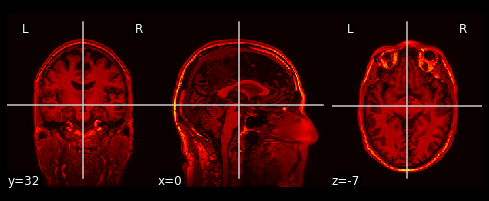

In [13]:
plotting.plot_epi(t1_img, cmap='hot')
plotting.show()

##Trabajo con la máscara




Por último, vamos a ver el contenido de la máscara

In [14]:
mask = nib.load(os.path.join(data_path, Mask_filename))
mask_header = mask.header
mask_data = mask.get_fdata()
mask_data.shape

(196, 256, 256)




Realizamos el plot de la máscara. En este caso, podemos observar que la máscara está generada sobre la materia gris.

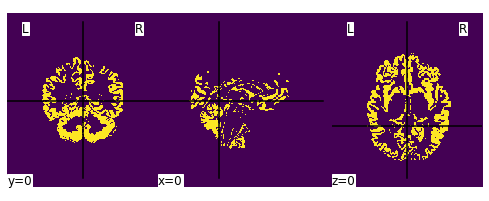

In [15]:
coordinates = (0,0,0)   # Podemos especificar unas coordenadas concretas para hacer las slices
plotting.plot_img(mask, coordinates)    # Esta es la función que usamos para hacer los plots de imagenes en general que no requieren presets
plotting.show()

A continuación, vamos a usar la máscara para obtener los valores de intensidad del T1 para los voxels que esta representa.

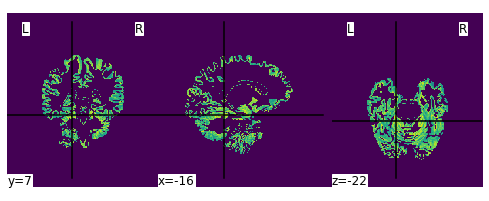

In [16]:
'''
#####
Lo que has hecho para calcular la mascara esta bien. Aun asi... ya que tabajamos con matrices, why not usar una approach matricial?
Computacionalmente, nose que es mas eficiente, pero para entender codigo, and for future uses, podrias hacerlo directamente

t1mask = np.multiply(mask_data, t1_img_data)

Esto te devuelve una matriz, y puedes seguir los mismos pasos que tienes: crear objeto Nifti y plotear
#####
'''

#masked = [x*y for x,y in zip(t1_data, mask_data)]   # Lista de comprensión con iteración sobre dos estructuras a la vez     # Evitaremos hacer esto e intentaremos usar funciones de numpy y/o pandas, que son librerias que se usan mucho en este campo

masked = np.multiply(t1_data, mask_data)
masked = np.reshape(masked, t1_data.shape)
masked_image = nib.Nifti1Image(masked, t1_img.affine, t1_img.header) #Con esta función creamos una nueva imagen a partir de los datos, header y affine que pasamos como parametro
plotting.plot_img(masked_image)
plotting.show()

A continuación mostramos el histograma de los distintos valores intensidad que presenta la región seleccionada por la máscara.

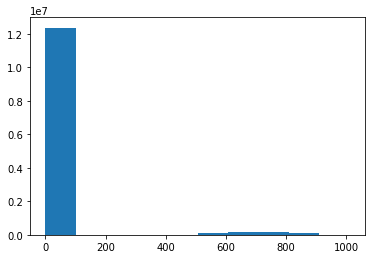

In [17]:
'''
#####
Same comment que con el PET. Prueva a usar reshape en vez de flatten, y haz un par mas de histogramas quitando los zeros
y valores bajos

En este caso se notan aun mas los zeros, porque nos hemos quedado SOLO con la parte de GM.
#####
'''
flatten_data_masked = masked.reshape(-1)
plt.hist(flatten_data_masked)
plt.show()

Como podemos apreciar en el histograma, hay una gran cantidad de zeros debido a que despueés de la aplicación de la máscara, nos quedamos solo con las intensidades de la región de materia gris.
Vamos a aplicar el mismo método que anteriormente.

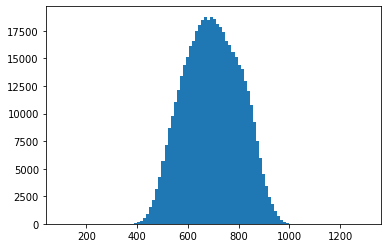

In [18]:
plt.hist(flatten_data_masked, range=(100,1300), bins=100)
plt.show()

##Trabajo con el Atlas

Cargamos el atlas y sus datos

In [19]:
atlas_img = nib.load(os.path.join(data_path, Atlas_filename))
atlas_header = atlas_img.header
atlas_data = atlas_img.get_fdata()
atlas_data.shape

(196, 256, 256)

Vamos a proceder a realizar un contaje de la cantidad de voxels que aparecen en las distinas ROI del atlas. Como los tags del atlas en realidad son valores discretos, en este caso plantearemos un grafico de barras.

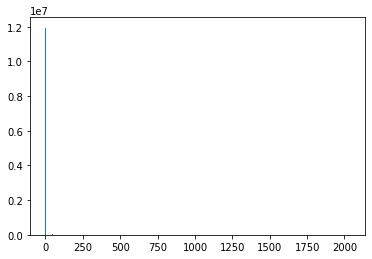

In [20]:
differents = np.unique(atlas_data)  # Nos quedamos con todos los tags diferentes del atlas
dict = {i: t1_data[atlas_data==i] for i in differents}  # Creamos un diccionario con los tags como claves y los datos de la imagen como valores
count = {i: len(dict[i]) for i in differents}   # Miramos cuantos datos hay por cada tag


plt.bar(differents, count.values())
plt.show()

Esta es una manera mucho más eficiente con la librería de pandas

<AxesSubplot:>

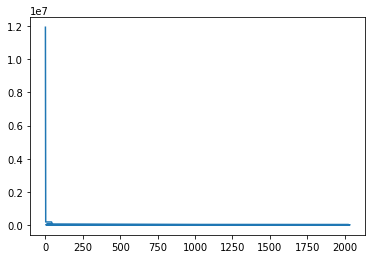

In [21]:
df = pd.DataFrame(atlas_data.reshape(-1), columns=['tags'])
ocurrences = df['tags'].value_counts()
ocurrences.plot()

Como podemos apreciar en el gráfico, la diferencia en el valor de los contages es tan alta que apenas se pueden apreciar las barras, de modo que plantearemos el mismo gráfico con valores logaritmicos.

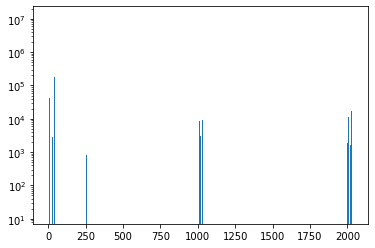

In [22]:
'''
#####
Este "problema" es normal que suceda, porque las regiones del atlas de GM son mucho mas grandes que las de GM. Por eso 
tienes esa gran diferencia.
El log es muy buena idea :)

Tambien, como te habras fijado, los indices del atlas no es continuo. Va haciendo saltos. 
El motivo es porque diferencia entre las regions subcorticales (i.e esas que NO estan en gray matter) y las regiones
corticales. Ademas, para cada hemisferio (i.e parte derecha vs parte isqueirda) tambien hay una diferencia de escala
Si te fijas en el histograma, los valores enrte 1000 y 2000 son de un hemisferio, y los valores entre 2000-x son del otro

Importante! Esto NO SIEMPRE es asi para todos los atlas. 
#####
'''

plt.bar(differents, count.values(), log=True)
plt.show()

Como se puede apreciar mejor en este gráfico logarítmico, hay tres regiones que podriamos destacar: las cercanas a 0, las cercanas a 1000 y las cercanas a 2000.
Esto es una peculiaridad de este atlas. Es debido a que cada una de estas zonas de tags referencia una parte diferente del cerebro.

Ahora vamos a plotear el atlas encima de nuestra imagen original T1.
Como podemos ver, aparecen destacados con diferentes colores los cortex de los dos hemisferios y estructuras subcorticales.

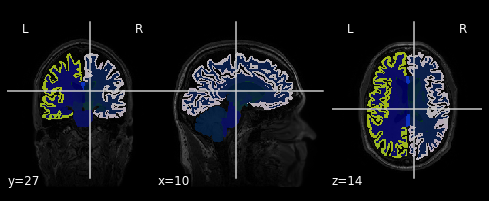

In [23]:
'''
#####
Prova aqui a fe run threshold de la mascara. 
Per el que hem dit abans, intenta quedarte amb les ROIs del hemisferi dret primer i despres del esquerra
i fer dos plotings diferents.
#####
'''
plotting.plot_roi(atlas_img, t1_img)
plotting.show()

Vamos a proceder a imprimir las 3 zonas de interes diferentes por separado.

Con la siguiente función auxiliar, filtraremos los datos de una imagen quedandonos con las regiones que nos interesan, que pasaremos como valores de máximo y minimo
Hay que tener en cuenta de que en esta función, solo pasaremos el image.data

In [24]:
def get_ROI(img, min, max):
    ROI = [ (x if (x>min and x<max) else 0) for x in img.reshape(-1)]
    #ROI = [ (x if y) for x,y in zip(img,np.zeros_like(img))]
    ROI = np.array(ROI)
    return ROI.reshape(img.shape)

Ahora ejecutaremos la función anterior para cada intervalo de valores de interés que hemos encontrado previamente

In [25]:
ROI_1_data = get_ROI(atlas_data, 0, 500)
ROI_2_data = get_ROI(atlas_data, 500, 1500)
ROI_3_data = get_ROI(atlas_data, 1500, 2500)

Por último, plotearmos las distintas zonas de interés por separado

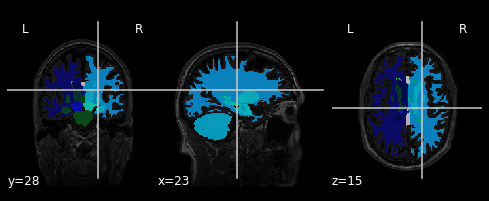

In [26]:
ROI_1 = nib.Nifti1Image(ROI_1_data, atlas_img.affine, atlas_img.header)
plotting.plot_roi(ROI_1, t1_img)
plotting.show()

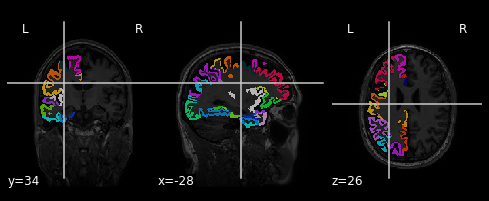

In [27]:
ROI_2 = nib.Nifti1Image(ROI_2_data, atlas_img.affine, atlas_img.header)
plotting.plot_roi(ROI_2, t1_img)
plotting.show()

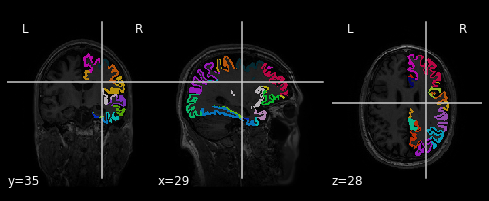

In [28]:
ROI_3 = nib.Nifti1Image(ROI_3_data, atlas_img.affine, atlas_img.header)
plotting.plot_roi(ROI_3, t1_img)
plotting.show()

Podemos hacer lo mismo superponiendo la PET a la T1 y disminuyendo su transparencia

Sin embargo, como podemos ver, debemos aplicar una corrección en el sistema de coordenadas

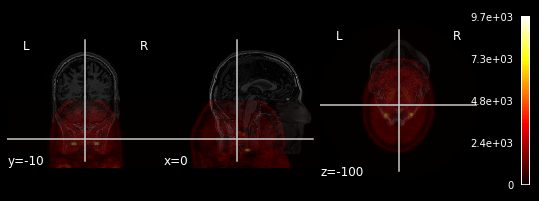

In [29]:
plotting.plot_stat_map(pet_img, t1_img, alpha=0.3)
plotting.show()

En este caso, vamos a aplicar la disminución de transparencia a la vez que un threshold de manera que solo nos muestre los puntos del PET donde el valor de intensidad es superior a 2000.

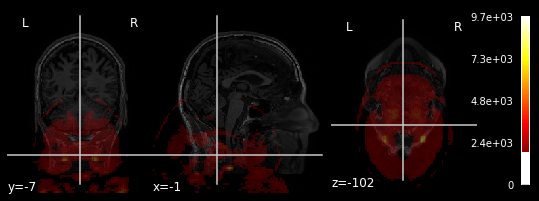

In [30]:
plotting.plot_stat_map(pet_img, t1_img, alpha=0.3, threshold=2000)
plotting.show()

Para cada una de las ROI del atlas, vamos a calcular el valor medio de las intensidades de la T1.

In [31]:
'''
#####
La solucion con diccionarios esta MUY bien.
Hay otras alternativas que podrias explorar, tho

Por ejemplo crear un DataFrame con PANDAS, e ir guardando los datos de la media ahi. Tambien facilita la exportacion.
Haz el testing. A lo largo de las practicas es muy probable que trabajemos con DataFrames
#####
'''
dict = {i: t1_data[atlas_data==i] for i in differents}  # Diccionario con todos los valores del atlas como claves y las intensidades de la imagen correspondientes como valores

average_intensities = {i: np.mean(dict[i]) for i in differents} # Diccionario con todos los valores del atlas como claves y las medias de las intensidades de la imagen correspondientes como valores

average_intensities

{0.0: 149.33306620586862,
 2.0: 1055.179085618232,
 4.0: 250.75123372833934,
 5.0: 373.4678056929922,
 7.0: 1026.4420324006255,
 8.0: 612.4496111984123,
 10.0: 940.3808751253941,
 11.0: 865.4968593801897,
 12.0: 895.1402222064161,
 13.0: 1087.7968904488985,
 14.0: 376.8121594605867,
 15.0: 326.34992704927856,
 16.0: 1054.5069261895767,
 17.0: 740.4232757893253,
 18.0: 805.5351902956219,
 24.0: 425.64272543289877,
 26.0: 808.1912330140459,
 28.0: 1073.590039434023,
 30.0: 659.131831577846,
 31.0: 554.2241477584294,
 41.0: 1055.2894188795192,
 43.0: 255.39957135873595,
 44.0: 308.36443932564396,
 46.0: 1077.062116150757,
 47.0: 676.3521343851161,
 49.0: 953.0904141474605,
 50.0: 854.6759201232095,
 51.0: 875.9633456323414,
 52.0: 1093.963838625087,
 53.0: 730.7481652607339,
 54.0: 806.5941257172527,
 58.0: 834.5483293468154,
 60.0: 1072.6709335382036,
 62.0: 582.6153363314542,
 63.0: 555.4648776255863,
 77.0: 809.842677613586,
 85.0: 1012.8300270547672,
 251.0: 1164.0698007761814,
 252.0

Y por último, vamos a guardar el diccionario que hemos creado previamente en un archivo csv

Ya que la solución anterior es bastante complicada, vamos a explorar diferentes alternativas a partir de funciones que nos ofrecen las diferentes librerias de python, en especial pandas, que nos ayuda a tratar con volumenes de datos multidimensionales.

In [32]:
df_intensities = pd.DataFrame(atlas_data.reshape(-1), columns=['tags'])
df_intensities['t1_intensities'] = t1_data.reshape(-1)
df_intensities.groupby('tags').mean()

,t1_intensities
tags,
0.0,149.333066
2.0,1055.179086
4.0,250.751234
5.0,373.467806
7.0,1026.442032
...,...
2031.0,654.319283
2032.0,816.883082
2033.0,687.422697


Por último, vamos a exportar los datos que hemos generado en el último ejercicio a un archivo CSV.

In [35]:
with open('media_intensidades_roi.csv', 'w') as out:
    writer = csv.writer(out)
    writer.writerow(['ROI', 'Media'])
    for key, value in average_intensities.items():
        writer.writerow([key, value])